# pre

In [2]:
from __future__ import annotations
# %pip uninstall mediocreatbest
%pip install --upgrade --force-reinstall \
    mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
try:
    from mediocreatbest import auto
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
    from mediocreatbest import auto


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git to /tmp/pip-install-pkns92yt/mediocreatbest_9a4b59eb502949238ad1687d7de76c25
  Running command git clone --filter=blob:none --quiet https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git /tmp/pip-install-pkns92yt/mediocreatbest_9a4b59eb502949238ad1687d7de76c25
  Resolved https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git to commit e41d8d653f5889dd403fed60135cfcf0de585704
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mediocreatbest: filename=mediocreatbest-0.2.33-py3-none-any.whl size=16364 sha256=5865919d6a5b3b61857512f2508547586e15bbb8712a977a39a785d89ebf18e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5kk2kp0a/wheels/cc/6d/dd/d4137c3485df0cb8773c136ecc231252590bf217127892aaa5


# lib

## Config

In [3]:
#@title Config { display-mode: "form" }
config = auto.types.SimpleNamespace()

/auto.pprint.pp config width=144


namespace()


## Spatial

In [4]:
#@title Spatial
class Spatial:
    Degree = auto.typing.NewType('Degree', float)
    Radian = auto.typing.NewType('Radian', float)
    Meter = auto.typing.NewType('Meter', float)
    Kilometer = auto.typing.NewType('Kilometer', float)

    def __new__(
        cls,
        *,
        lat: Degree,
        lng: Degree,
        alt: Meter,
    ) -> tuple[Kilometer, Kilometer, Kilometer]:
        Degree = cls.Degree
        Radian = cls.Radian
        Meter = cls.Meter
        Kilometer = cls.Kilometer

        # Thanks https://gis.stackexchange.com/a/4148

        #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and
        #> phi/theta/rho are just another name for latitude, longitude, and altitude.
        #> :) (A minor difference: altitude is usually measured from the surface of the
        #> sphere; rho is measured from the center -- to convert, just add/subtract the
        #> radius of the sphere.)
        phi: Radian = auto.np.radians(lat)
        theta: Radian = auto.np.radians(lng)

        # Thanks https://en.wikipedia.org/wiki/Earth_radius
        #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
        rho: Kilometer = 6_371 + alt / 1000.0

        #> x = math.cos(phi) * math.cos(theta) * rho
        x: Kilometer = auto.np.cos(phi) * auto.np.cos(theta) * rho

        #> y = math.cos(phi) * math.sin(theta) * rho
        y: Kilometer = auto.np.cos(phi) * auto.np.sin(theta) * rho

        #> z = math.sin(phi) * rho # z is 'up'
        z: Kilometer = auto.np.sin(phi) * rho

        #> (Note there's some slightly arbitrary choices here in what each axis means...
        #> you might want 'y' to point at the north pole instead of 'z', for example.)

        # I do :)
        y, z = z, y

        return x, y, z


# 1st: IDF -> JSON

## config.app

In [4]:
config.app = auto.types.SimpleNamespace()

# Added the '/raw' to the end which is where the Knox... csv file is found
config.app.datadir = auto.pathlib.Path('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/raw')
assert config.app.datadir.exists()

config.app.buildings = config.app.datadir / 'Knox_Henderson_TN_MAv1.csv'
assert config.app.buildings.exists()

config.app.things = {}
config.app.things['Knox'] = auto.zipfile.Path(config.app.datadir / 'Knox.zip')
config.app.things['Henderson'] = auto.zipfile.Path(config.app.datadir / 'Henderson.zip')

/auto.pprint.pp config.app width=144


namespace(datadir=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/raw'),
          buildings=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/raw/Knox_Henderson_TN_MAv1.csv'),
          things={'Knox': Path('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/raw/Knox.zip', ''),
                  'Henderson': Path('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/raw/Henderson.zip', '')})


## Unit

In [5]:
#@title Unit
@auto.functools.cache
def Unit():
    unit = auto.pint.UnitRegistry()

    return unit

_ = Unit()


## Thing

In [6]:
#@title Thing
@auto.dataclasses.dataclass(frozen=True, kw_only=True)
class Thing:
    sections: auto.collections.OrderedDict

    @classmethod
    def parse(Thing, text: str, /):
        T_Section = auto.collections.namedtuple('Section', 'name')
        T_Field = auto.collections.namedtuple('Field', 'name value')

        def Lex(text: str, /) -> auto.typing.Iterator[T_Section | T_Field]:
            SECTION = auto.re.compile(r'''
                (?P<name>.+?)
                ,
                (?:\n|$)
            ''', auto.re.X)

            FIELD = auto.re.compile(r'''
                \s+
                (?P<value>.+?)
                (?P<more>[,;])
                \s+
                !-
                \s+
                (?P<name>.+?)
                (?:\n|$)
            ''', auto.re.X)

            text = text.strip()

            start = 0
            while start < len(text):
                match = SECTION.search(text, start)
                assert match is not None, \
                    f'{text[start-128:][:128]}<->{text[start:]}'
                start = match.end()

                yield T_Section(name=match.group('name'))

                while True:
                    match = FIELD.search(text, start)
                    assert match is not None
                    start = match.end()

                    yield T_Field(name=match.group('name'), value=match.group('value'))

                    if match.group('more') == ';':
                        break

        sections = {}
        fields = None
        for token in Lex(text):
            match token:
                case T_Section(name):
                    # assert name not in ret
                    sections.setdefault(name, []).append(fields := {})
                case T_Field(name, value):
                    # assert value not in section[name]
                    fields.setdefault(name, []).append(value)
                case _:
                    raise NotImplementedError()

        return Thing(
            sections=sections,
        )


## Location

In [7]:
#@title Location
@auto.dataclasses.dataclass(frozen=True, kw_only=True)
class Location:
    lat: float
    lng: float

    @classmethod
    @auto.mediocreatbest.doctest
    def parse(Location, s: str, /):
        r"""

        >>> parse(dict, "35.4963185/-88.468932")
        {'lat': 35.4963185, 'lng': -88.468932}

        """
        lat, lng = s.split('/')
        lat = float(lat)
        lng = float(lng)

        return Location(
            lat=lat,
            lng=lng,
        )


## Bounds

In [8]:
#@title Bounds
@auto.dataclasses.dataclass(frozen=True, kw_only=True)
class Bounds:
    sw: Location
    ne: Location

    def __post_init__(self):
        assert self.sw.lat <= self.ne.lat
        assert self.sw.lng <= self.ne.lng


## Building

In [9]:
#@title Building
@auto.dataclasses.dataclass(frozen=True, kw_only=True)
class Building:
    identifier: str
    centroid: Location
    footprint: list[Location]
    state: str
    volume: auto.pint.Quantity
    area: auto.pint.Quantity
    height: auto.pint.Quantity
    floors: int
    kind: str
    standard: str
    center: Location
    county: str

    @classmethod
    @auto.mediocreatbest.doctest
    def parse(Building, row: auto.df.Series, /) -> auto.typing.Self:
        r"""

        >>> parse(dict, {
        ...     'ID': 6022005286564,
        ...     'Centroid': '35.4963185/-88.468932',
        ...     'Footprint2D': '35.49638/-88.468974_35.49638/-88.46889_35.496257/-88.46889_35.496257/-88.468974',
        ...     'State': 'TN',
        ...     'Area': 5071.597932155534,
        ...     'Area2D': 724.5139903079335,
        ...     'Height_m': 20.68000066176,
        ...     'NumFloors': 7.0,
        ...     'WWR_surfaces': '.15_.15_.15_.15',
        ...     'CZ': '3A',
        ...     'BuildingType': 'MidriseApartment',
        ...     'Standard': 'DOE-Ref-Pre-1980',
        ...     'lat': 35.4963185,
        ...     'lon': -88.468932,
        ...     '.points': 'POINT (-88.468932 35.4963185)',
        ...     'index_right': 0,
        ...     'City': 'Henderson'})
        ... #doctest: +NORMALIZE_WHITESPACE
        {'identifier': 6022005286564,
        'centroid': Location(lat=35.4963185, lng=-88.468932),
        'footprint': [Location(lat=35.49638, lng=-88.468974),
                    Location(lat=35.49638, lng=-88.46889),
                    Location(lat=35.496257, lng=-88.46889),
                    Location(lat=35.496257, lng=-88.468974)],
        'state': 'TN',
        'volume': <Quantity(5071.59793, 'meter ** 3')>,
        'area': <Quantity(724.51399, 'meter ** 2')>,
        'height': <Quantity(20.6800007, 'meter')>,
        'floors': 7.0,
        'kind': 'MidriseApartment',
        'standard': 'DOE-Ref-Pre-1980',
        'center': Location(lat=35.4963185, lng=-88.468932),
        'county': 'Henderson'}

        """

        unit = Unit()

        identifier = row['ID']
        centroid = Location.parse(row['Centroid'])
        footprint = [Location.parse(p) for p in row['Footprint2D'].split('_')]
        state = row['State']
        volume = row['Area'] * unit.meter ** 3
        area = row['Area2D'] * unit.meter ** 2
        height = row['Height_m'] * unit.meter
        floors = row['NumFloors']
        kind = row['BuildingType']
        standard = row['Standard']
        center = Location(
            lat=row['lat'],
            lng=row['lon'],
        )
        county = row['City']

        return Building(
            identifier=identifier,
            centroid=centroid,
            footprint=footprint,
            state=state,
            volume=volume,
            area=area,
            height=height,
            floors=floors,
            kind=kind,
            standard=standard,
            center=center,
            county=county,
        )

    @auto.functools.cached_property
    def url(building: Building, /) -> str:
        return (
            f'http://maps.google.com/maps'
            f'?z=12'
            f'&t=k'
            f'&q=loc:{building.centroid.lat}+{building.centroid.lng}'
        )

    @auto.functools.cached_property
    def bounds(building: Building, /) -> Bounds:
        n = e = float('-inf')
        s = w = float('inf')

        for location in building.footprint:
            n = max(n, location.lat)
            s = min(s, location.lat)
            w = min(w, location.lng)
            e = max(e, location.lng)

        return Bounds(
            sw=Location(lng=w, lat=s),
            ne=Location(lng=e, lat=n),
        )

    # @auto.functools.cached_property
    @property
    def osm(building: Building, /) -> dict[str, list[dict[str, list[str]]]]:
        root = config.app.things[building.county]
        path = root / 'ModelsOrig' / f'{building.identifier}' / f'{building.identifier}.osm'
        with path.open('r') as f:
            return Thing.parse(f.read())

    # @auto.functools.cached_property
    @property
    def idf(building: Building, /) -> dict[str, list[dict[str, list[str]]]]:
        root = config.app.things[building.county]
        path = root / 'ModelsOrig' / f'{building.identifier}' / f'{building.identifier}.idf'
        with path.open('r') as f:
            return Thing.parse(f.read())


## Buildings

In [10]:
#@title Buildings
class Buildings(auto.collections.UserList[Building]):
    @classmethod
    def parse(Buildings, fileobj, /, nrows=None):
        df = auto.pd.read_csv(
            fileobj,
            nrows=nrows,
        )

        buildings = Buildings()
        for _, row in auto.tqdm.notebook.tqdm(df.iterrows(), total=len(df)):
            buildings.append(Building.parse(row))

        return buildings

    @auto.functools.cached_property
    def knox(buildings_, /):
        buildings = Buildings()
        for building in buildings_:
            if building.county == 'Knox':
                buildings.append(building)

        return buildings

    @auto.functools.cached_property
    def henderson(buildings_, /):
        buildings = Buildings()
        for building in buildings_:
            if building.county == 'Henderson':
                buildings.append(building)

        return buildings

    @auto.functools.cached_property
    def bounds(buildings: Buildings, /) -> Bounds:
        n = e = float('-inf')
        s = w = float('inf')

        for building in buildings:
            bounds = building.bounds()
            n = max(n, bounds.ne.lat)
            s = min(s, bounds.sw.lat)
            w = min(w, bounds.sw.lng)
            e = max(e, bounds.ne.lng)

        return Bounds(
            sw=Location(lng=w, lat=s),
            ne=Location(lng=e, lat=n),
        )


In [ ]:
def scope():
    !ls -l {config.app.datadir}

/scope


In [ ]:
buildings = Buildings.parse(config.app.buildings, nrows=10)
/print len(buildings)


In [ ]:
with auto.mediocreatbest.Textarea():
    auto.pprint.pp(buildings[0].osm)

with auto.mediocreatbest.Textarea():
    auto.pprint.pp(buildings[0].idf)


## look

In [ ]:
#@title look
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    parser.add_argument('what', type=str)
    args = parser.parse_args(auto.shlex.split(args))

    def scope():
        for building in buildings:
            what = getattr(building, args.what)
            for section, values in what.sections.items():
                for fields in values:
                    for field, values in fields.items():
                        for value in values:
                            yield (section, field, value)

    rest = sorted(scope())
    s2c = auto.collections.Counter()
    sf2c = auto.collections.Counter()
    for section, field, value in rest:
        s2c[section] += 1
        sf2c[section, field] += 1

    with auto.mediocreatbest.Textarea():
        rest = sorted(scope(), key=lambda x: (-s2c[x[0]], x[0]))
        for section, rest in auto.itertools.groupby(rest, key=lambda x: x[0]):
            rest = list(rest)
            print(f'# {auto.json.dumps(section)} = {len(rest)}')

            for field, rest in auto.itertools.groupby(rest, key=lambda x: x[1]):
                for value in rest:
                    break

    with auto.mediocreatbest.Textarea():
        rest = sorted(scope(), key=lambda x: (-s2c[x[0]], x[0], -sf2c[x[0],x[1]], x[1]))
        for section, rest in auto.itertools.groupby(rest, key=lambda x: x[0]):
            for field, rest in auto.itertools.groupby(rest, key=lambda x: x[1]):
                rest = list(rest)
                print((
                    f'# {auto.json.dumps(section)} / '
                    f'{auto.json.dumps(field)} '
                    f'= {len(rest)}'
                ))

                for value in rest:
                    break

    with auto.mediocreatbest.Textarea():
        rest = sorted(scope(), key=lambda x: (-s2c[x[0]], x[0], -sf2c[x[0],x[1]], x[1]))
        for section, rest in auto.itertools.groupby(rest, key=lambda x: x[0]):
            for field, rest in auto.itertools.groupby(rest, key=lambda x: x[1]):
                for _, _, value in rest:
                    break

                print((
                    f'{auto.json.dumps(section)} / '
                    f'{auto.json.dumps(field)} = '
                    f'{auto.json.dumps(value)}'
                ))

;scope osm
;scope idf


In [ ]:
buildings = Buildings.parse(config.app.buildings)
/print len(buildings)


## save

In [ ]:
#@title save
def scope():
    # path = auto.pathlib.Path('/mnt/data') / 'buildings.zip'
    # if path.exists():
    #     path.unlink()

    # with auto.zipfile.ZipFile(path, 'w', compression=auto.zipfile.ZIP_DEFLATED) as arc:
    #     root = auto.zipfile.Path(arc)

    root = auto.pathlib.Path('/mnt/seenas2/data') / 'buildings'
    # root = auto.pathlib.Path('/mnt/data') / 'buildings'
    root.mkdir(exist_ok=True)

    with auto.contextlib.ExitStack() as stack:
        pbar = stack.enter_context( auto.tqdm.auto.tqdm(unit='building') )
        ebar = stack.enter_context( auto.tqdm.auto.tqdm(unit='error') )

        pbar.reset(total=len(buildings))
        for building in buildings:
            pbar.update()

            # path = root / f'{building.identifier}' / 'osm.json.gz'
            # path.parent.mkdir(exist_ok=True)
            # if not path.exists():
            #     try:
            #         osm = building.osm
            #     except KeyboardInterrupt:
            #         raise
            #     except:
            #         ebar.update()
            #         pass
            #     else:
            #         with auto.gzip.open(path, 'wb') as f:
            #             with auto.io.TextIOWrapper(f, encoding='utf-8') as f:
            #                 auto.json.dump(osm.sections, f)

            path = root / f'{building.identifier}' / 'idf.json.gz'
            path.parent.mkdir(exist_ok=True)

            if path.exists() and path.stat().st_size < 1000:
                path.unlink()

            if not path.exists():
                try:
                    idf = building.idf
                except KeyboardInterrupt:
                    raise
                except:
                    ebar.update()
                    pass
                else:
                    with auto.gzip.open(path, 'wb') as f:
                        with auto.io.TextIOWrapper(f, encoding='utf-8') as f:
                            auto.json.dump(idf.sections, f)

            path = root / f'{building.identifier}' / 'building.json'
            path.parent.mkdir(exist_ok=True)
            if not path.exists():
                with path.open('w') as f:
                    f.write(auto.json.dumps({
                        'identifier': building.identifier,
                        'centroid': {
                            'lat': building.centroid.lat,
                            'lng': building.centroid.lng,
                        },
                        'footprint': [
                            {
                                'lat': p.lat,
                                'lng': p.lng,
                            }
                            for p in building.footprint
                        ],
                        'state': building.state,
                        'volume': building.volume.m_as(Unit().meter ** 3),
                        'area': building.area.m_as(Unit().meter ** 2),
                        'height': building.height.m_as(Unit().meter),
                        'floors': building.floors,
                        'kind': building.kind,
                        'standard': building.standard,
                        'center': {
                            'lat': building.center.lat,
                            'lng': building.center.lng,
                        },
                        'county': building.county,
                    }))

/scope


In [ ]:
def scope():
    root = auto.pathlib.Path('/mnt/data') / 'buildings'
    total = 0
    for path in root.glob('*/idf.json.gz'):
        total += path.stat().st_size
    for path in root.glob('*/building.json'):
        total += path.stat().st_size

    print(f'{total :,d} bytes')

/scope


In [ ]:
# def scope():
#     root = auto.pathlib.Path('/mnt/data') / 'buildings'
#     paths = []
#     for path in root.glob('*/idf.json.gz'):
#         paths.append(path)
#     for path in root.glob('*/building.json'):
#         paths.append(path)

#     paths = sorted(paths)
#     print(paths[:10])

#     path = auto.pathlib.Path('/mnt/data') / 'buildings.zip'
#     path.parent.mkdir(exist_ok=True)
#     if path.exists():
#         path.unlink()

#     with auto.zipfile.ZipFile(path, 'w') as arc:
#         root = auto.zipfile.Path(arc)

#         for src in auto.tqdm.auto.tqdm(paths):
#             dst = root / src.parent.name / src.name
#             with path.open('rb') as s, dst.open('wb') as d:
#                 auto.shutil.copyfileobj(s, d)

#     print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

# /scope


# 2nd: IDF JSON -> Simple JSON

## config.app

In [ ]:
config.app = auto.types.SimpleNamespace()

config.app.datadir = auto.pathlib.Path((
    '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/buildings/buildings'
))

/auto.pprint.pp config.app width=144


## Surfaces

In [ ]:
#@title Surfaces
def Surfaces(building: str, /, *, verbose: bool = False, cls = auto.types.SimpleNamespace):
    with (config.app.datadir / building / 'idf.json.gz').open('rb') as f:
        with auto.gzip.open(f) as f:
            idf = auto.json.load(f)

    if verbose:
        with auto.mediocreatbest.Textarea():
            print(auto.json.dumps(idf, indent=2))

    def Name(what):
        if hasattr(what, 'name'):
            return what.name
        return what['name']

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            _ ,= json.pop('Roughness')
            thickness ,= json.pop('Thickness {m}', [None])
            conductivity ,= json.pop('Conductivity {W/m-K}', [None])
            density ,= json.pop('Density {kg/m3}', [None])
            specific_heat ,= json.pop('Specific Heat {J/kg-K}', [None])
            thermal_absorptance ,= json.pop('Thermal Absorptance')
            solar_absorptance ,= json.pop('Solar Absorptance')
            visible_absorptance ,= json.pop('Visible Absorptance')
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            return float(s)
        thickness = scope(thickness)
        conductivity = scope(conductivity)
        density = scope(density)
        specific_heat = scope(specific_heat)
        thermal_absorptance = scope(thermal_absorptance)
        solar_absorptance = scope(solar_absorptance)
        visible_absorptance = scope(visible_absorptance)

        return [cls(
            name=name,
            thickness=thickness,
            conductivity=conductivity,
            density=density,
            specific_heat=specific_heat,
            thermal_absorptance=thermal_absorptance,
            solar_absorptance=solar_absorptance,
            visible_absorptance=visible_absorptance,
        )]

    materials = []
    for json in idf['Material']:
        materials.extend(scope(json))
    materials = { Name(m): m for m in materials }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp materials width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            _ ,= json.pop('Roughness')
            thermal_resistance ,= json.pop('Thermal Resistance {m2-K/W}')
            thermal_absorptance ,= json.pop('Thermal Absorptance')
            solar_absorptance ,= json.pop('Solar Absorptance')
            visible_absorptance ,= json.pop('Visible Absorptance')
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            return float(s)
        thermal_resistance = scope(thermal_resistance)
        thermal_absorptance = scope(thermal_absorptance)
        solar_absorptance = scope(solar_absorptance)
        visible_absorptance = scope(visible_absorptance)

        return [cls(
            name=name,
            thermal_resistance=thermal_resistance,
            thermal_absorptance=thermal_absorptance,
            solar_absorptance=solar_absorptance,
            visible_absorptance=visible_absorptance,
        )]

    nomasses = []
    for json in idf['Material:NoMass']:
        nomasses.extend(scope(json))
    nomasses = { Name(m): m for m in nomasses }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp nomasses width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            _ ,= json.pop('Optical Data Type')
            _ ,= json.pop('Window Glass Spectral Data Set Name')
            thickness ,= json.pop('Thickness {m}')
            solar_transmittance ,= json.pop('Solar Transmittance at Normal Incidence')
            front_solar_reflectance ,= json.pop('Front Side Solar Reflectance at Normal Incidence')
            back_solar_reflectance ,= json.pop('Back Side Solar Reflectance at Normal Incidence')
            visible_transmittance ,= json.pop('Visible Transmittance at Normal Incidence')
            front_visible_reflectance ,= json.pop('Front Side Visible Reflectance at Normal Incidence')
            back_visible_reflectance ,= json.pop('Back Side Visible Reflectance at Normal Incidence')
            infrared_transmittance ,= json.pop('Infrared Transmittance at Normal Incidence')
            front_infrared_emissivity ,= json.pop('Front Side Infrared Hemispherical Emissivity')
            back_infrared_emissivity ,= json.pop('Back Side Infrared Hemispherical Emissivity')
            conductivity ,= json.pop('Conductivity {W/m-K}')
            _ ,= json.pop('Dirt Correction Factor for Solar and Visible Transmittance')
            _ ,= json.pop('Solar Diffusing')
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            return float(s)
        thickness = scope(thickness)
        solar_transmittance = scope(solar_transmittance)
        front_solar_reflectance = scope(front_solar_reflectance)
        back_solar_reflectance = scope(back_solar_reflectance)
        visible_transmittance = scope(visible_transmittance)
        front_visible_reflectance = scope(front_visible_reflectance)
        back_visible_reflectance = scope(back_visible_reflectance)
        infrared_transmittance = scope(infrared_transmittance)
        front_infrared_emissivity = scope(front_infrared_emissivity)
        back_infrared_emissivity = scope(back_infrared_emissivity)
        conductivity = scope(conductivity)

        return [cls(
            name=name,
            thickness=thickness,
            solar_transmittance=solar_transmittance,
            front_solar_reflectance=front_solar_reflectance,
            back_solar_reflectance=back_solar_reflectance,
            visible_transmittance=visible_transmittance,
            front_visible_reflectance=front_visible_reflectance,
            back_visible_reflectance=back_visible_reflectance,
            infrared_transmittance=infrared_transmittance,
            front_infrared_emissivity=front_infrared_emissivity,
            back_infrared_emissivity=back_infrared_emissivity,
            conductivity=conductivity,
        )]

    windows = []
    for json in idf['WindowMaterial:Glazing']:
        windows.extend(scope(json))
    windows = { Name(w): w for w in windows }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp windows width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            u_factor ,= json.pop('U-Factor {W/m2-K}')
            solar_heat_gain_coefficient ,= json.pop('Solar Heat Gain Coefficient')
            visible_transmittance ,= json.pop('Visible Transmittance')
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            return float(s)
        u_factor = scope(u_factor)
        solar_heat_gain_coefficient = scope(solar_heat_gain_coefficient)
        visible_transmittance = scope(visible_transmittance)

        return [cls(
            name=name,
            u_factor=u_factor,
            solar_heat_gain_coefficient=solar_heat_gain_coefficient,
            visible_transmittance=visible_transmittance,
        )]

    simple_windows = []
    for json in idf.get('WindowMaterial:SimpleGlazingSystem', []):
        simple_windows.extend(scope(json))
    simple_windows = { Name(w): w for w in simple_windows }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp simple_windows width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            type ,= json.pop('Gas Type')
            thickness ,= json.pop('Thickness {m}')
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            return float(s)
        thickness = scope(thickness)

        return [cls(
            name=name,
            type=type,
            thickness=thickness,
        )]

    gas = []
    for json in idf.get('WindowMaterial:Gas', []):
        gas.extend(scope(json))
    gas = { Name(g): g for g in gas }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp gas width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            layer1 ,= json.pop('Layer 1')
            layer2 ,= json.pop('Layer 2', [None])
            layer3 ,= json.pop('Layer 3', [None])
            layer4 ,= json.pop('Layer 4', [None])
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(layer):
            if layer is None:
                return []

            def scope(type_, lookup):
                nonlocal type, mat
                try:
                    mat = lookup[layer]
                except KeyError:
                    pass
                else:
                    type = type_

            type = None
            mat = None
            scope('Material', materials)
            scope('NoMass', nomasses)
            scope('Window', windows)
            scope('SimpleWindow', simple_windows)
            scope('Gas', gas)
            assert type is not None, layer
            assert mat is not None, layer
            return [cls(
                name=layer,
                type=type,
                material=mat,
            )]
        layers = []
        layers.extend(scope(layer1))
        layers.extend(scope(layer2))
        layers.extend(scope(layer3))
        layers.extend(scope(layer4))
        layers = { Name(l): l for l in layers }

        return [cls(
            name=name,
            layers=layers,
        )]

    constructions = []
    for json in idf['Construction']:
        constructions.extend(scope(json))
    constructions = { Name(c): c for c in constructions }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp constructions width=144

    ffactor_constructions = set()
    for json in idf.get('Construction:FfactorGroundFloor', []):
        ffactor_constructions.add(json['Name'][0])
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp ffactor_constructions width=144

    def scope(json):
        json = json.copy()
        try:
            name ,= json.pop('Name')
            surface_type ,= json.pop('Surface Type')
            construction ,= json.pop('Construction Name')
            zone_name ,= json.pop('Zone Name')
            _ = json.pop('Outside Boundary Condition')
            _ = json.pop('Outside Boundary Condition Object')
            sun_exposure ,= json.pop('Sun Exposure')
            wind_exposure ,= json.pop('Wind Exposure')
            _ = json.pop('View Factor to Ground')
            _ = json.pop('Number of Vertices')
            _ = json.pop('Frame and Divider Name', None)
            _ = json.pop('Multiplier', None)
            vs = []
            for i in range(32):
                v ,= json.pop(f'X,Y,Z Vertex {1+i} {{m}}', [None])
                if v is not None:
                    vs.append(v)
            assert not json, list(json)
        except KeyboardInterrupt:
            raise
        except:
            print(json)
            raise

        def scope(s):
            if s in ffactor_constructions:
                return None
            return constructions[s]
        construction = scope(construction)
        if construction is None:
            return []

        def scope(s):
            if s == 'NoSun':
                return False
            elif s == 'SunExposed':
                return True
            else:
                raise ValueError(s)
        sun_exposure = scope(sun_exposure)

        def scope(s):
            if s == 'NoWind':
                return False
            elif s == 'WindExposed':
                return True
            else:
                raise ValueError(s)
        wind_exposure = scope(wind_exposure)

        def scope(v):
            if v is None:
                return []
            x, y, z = auto.re.split(r'\s*,\s*', v)
            x, y, z = map(float, (x, y, z))
            return [cls(
                x=x,
                y=y,
                z=z,
            )]

        vertices = []
        for v in vs:
            vertices.extend(scope(v))

        return [cls(
            name=name,
            surface_type=surface_type,
            construction=construction,
            zone_name=zone_name,
            sun_exposure=sun_exposure,
            wind_exposure=wind_exposure,
            vertices=vertices,
        )]

    surfaces = []
    for json in idf['BuildingSurface:Detailed']:
        surfaces.extend(scope(json))
    surfaces = { Name(s): s for s in surfaces }
    if verbose:
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp surfaces width=144

    return surfaces


def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument 'building' type=str
    args = parser.parse_args(auto.shlex.split(args))

    _ = Surfaces(args.building, verbose=True)

# ;scope 6030007461626
# ;scope 6031007687580
# ;scope 6030007430502
# ;scope 6030007473275
;scope 6030007420684


## look

In [ ]:
#@title look
def scope():
    Random = auto.mediocreatbest.RANDOM(seed=1337)

    root = config.app.datadir
    paths = sorted(root.glob('*/'))
    paths = Random(0).sample(paths, 100)

    for path in paths:
        building = path.name
        /print building

        surfaces = Surfaces(building)
        with auto.mediocreatbest.Textarea():
            /auto.pprint.pp surfaces width=144

/scope


## save

In [ ]:
#@title save
def scope():
    with auto.contextlib.ExitStack() as stack:
        pbar = stack.enter_context( auto.tqdm.auto.tqdm(unit='building') )
        ebar = stack.enter_context( auto.tqdm.auto.tqdm(unit='error') )

        root = config.app.datadir
        paths = sorted(root.glob('*/'))

        root = auto.pathlib.Path('/mnt/data/buildings')
        pbar.reset(total=len(paths))
        for path in paths:
            /pbar.update

            building = path.name

            path = root / building / f'surfaces.json'
            if path.exists() and path.stat().st_size < 1000:
                path.unlink()

            if not path.exists():
                try:
                    surfaces = Surfaces(building, cls=dict)
                except FileNotFoundError:
                    /ebar.update
                    continue
                except auto.json.JSONDecodeError as e:
                    /ebar.update
                    continue

                with path.open('w') as f:
                    auto.json.dump(surfaces, f)

/scope


# 3rd: Simple JSON -> CSV -> SQLite

## config.app

In [5]:
config.app = auto.types.SimpleNamespace()

config.app.datadir = auto.pathlib.Path((
    '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/buildings'
))

/auto.pprint.pp config.app width=144


namespace(datadir=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/buildings'))


In [7]:
def scope(args: str, /) -> None:
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument 'building' type=str
    args = parser.parse_args(auto.shlex.split(args))

    path = config.app.datadir / args.building / f'building.json'
    with path.open('r') as f:
        building = auto.json.load(f)
    with auto.mediocreatbest.Textarea():
        /auto.pprint.pp building width=144

    path = config.app.datadir / args.building / f'surfaces.json'
    with path.open('r') as f:
        surfaces = auto.json.load(f)
    with auto.mediocreatbest.Textarea():
        /auto.pprint.pp surfaces width=144

;scope 6022005305275


## HASH

In [8]:
#@title HASH
def HASH(pre, /, *, seed = None, N = 8):
    seen = set()
    count = iter(auto.itertools.count())

    def H(x):
        h = auto.hashlib.sha256((
            f'{seed}-{x}'.encode()
        ) if seed is not None else (
            f'{x}'.encode()
        )).hexdigest()
        h = h.upper()
        return (pre + h)[:N]

    def Hash():
        for _ in range(1000):
            h = H(next(count))
            if h not in seen:
                seen.add(h)
                return h

        raise ValueError('Too many collisions')

    return Hash


## save CSV

In [14]:
def scope(args: str, /) -> None:
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int
    args = parser.parse_args(auto.shlex.split(args))

    HBUILDING = HASH('B0', seed='63b5b7f1-f680-4adb-8ab4-9f44470bcf13', N=8)
    BUILDING = auto.typing.NamedTuple('BUILDING', [
        ('identity', int),
        ('hashname', str),
        ('identifier', int),
        ('centroid', str),
        ('footprint', str),
        ('state', str),
        ('volume', float),
        ('area', float),
        ('height', float),
        ('floors', float),
        ('kind', str),
        ('standard', str),
        ('center', str),
        ('county', str),
    ])

    HSURFACE = HASH('S0', seed='7392c196-a733-4974-88b5-8c7ae325d7ef', N=32)
    SURFACE = auto.typing.NamedTuple('SURFACE', [
        ('identity', int),
        ('hashname', str),
        ('name', str),
        ('surface_type', str),
        ('construction', int),
        ('zone_name', str),
        ('sun_exposure', bool),
        ('wind_exposure', bool),
        ('vertices', str),
    ])

    HBUILDING_SURFACE = HASH('BS0', seed='8e463bb9-5c7a-4112-be6c-cfc3a1ffeaf8', N=32)
    BUILDING_SURFACE = auto.typing.NamedTuple('BUILDING_SURFACE', [
        ('identity', int),
        ('hashname', str),
        ('building', int),
        ('surface', int),
    ])

    HLAYER = HASH('L0', seed='ae56115a-477b-4284-94f4-1427b83c368e', N=32)
    LAYER = auto.typing.NamedTuple('LAYER', [
        ('identity', int),
        ('hashname', str),
        ('name', str),
        ('type', str),
        ('material', str),
    ])

    HSURFACE_LAYER = HASH('SL0', seed='9042816a-615b-44f9-922f-c7ae7b74063e', N=32)
    SURFACE_LAYER = auto.typing.NamedTuple('SURFACE_LAYER', [
        ('identity', int),
        ('hashname', str),
        ('surface', int),
        ('layer', int),
    ])

    root = config.app.datadir
    paths = sorted(root.glob('*/'))
    if args.limit is not None:
        paths = paths[:args.limit]

    for path in auto.tqdm.auto.tqdm(paths.copy()):
        if not (path / f'building.json').exists():
            paths.remove(path)
        if not (path / f'surfaces.json').exists():
            paths.remove(path)

    db = auto.types.SimpleNamespace(
        buildings = {},
        surfaces = {},
        building_surfaces = {},
        layers = {},
        surface_layers = {},
    )

    for root in auto.tqdm.auto.tqdm(paths):
        with (root / f'building.json').open() as f:
            building = auto.json.load(f)
        with (root / f'surfaces.json').open() as f:
            surfaces = auto.json.load(f)

        db.building = db.buildings.get((key := (
            building['identifier'],
        )), None)
        if db.building is None:
            db.buildings[key] = \
            db.building = BUILDING(
                identity = 1 + len(db.buildings),
                hashname = HBUILDING(),
                identifier = building['identifier'],
                centroid = auto.json.dumps(building['centroid']),
                footprint = auto.json.dumps(building['footprint']),
                state = building['state'],
                volume = building['volume'],
                area = building['area'],
                height = building['height'],
                floors = building['floors'],
                kind = building['kind'],
                standard = building['standard'],
                center = auto.json.dumps(building['center']),
                county = building['county'],
            )

        for surface in surfaces.values():
            db.surface = db.surfaces.get((key := (
                building['identifier'],
                surface['name'],
            )), None)
            if db.surface is None:
                db.surfaces[key] = \
                db.surface = SURFACE(
                    identity = 1 + len(db.surfaces),
                    hashname = HSURFACE(),
                    name = surface['name'],
                    surface_type = surface['surface_type'],
                    construction = surface['construction'],
                    zone_name = surface['zone_name'],
                    sun_exposure = surface['sun_exposure'],
                    wind_exposure = surface['wind_exposure'],
                    vertices = auto.json.dumps(surface['vertices']),
                )

            db.building_surface = db.building_surfaces.get((key := (
                building['identifier'],
                surface['name'],
            )), None)
            if db.building_surface is None:
                db.building_surfaces[key] = \
                db.building_surface = BUILDING_SURFACE(
                    identity = 1 + len(db.building_surfaces),
                    hashname = HBUILDING_SURFACE(),
                    building = db.building.identity,
                    surface = db.surface.identity,
                )

            for layer in surface['construction']['layers'].values():
                db.layer = db.layers.get((key := (
                    building['identifier'],
                    surface['name'],
                    layer['name'],
                )), None)
                if db.layer is None:
                    db.layers[key] = \
                    db.layer = LAYER(
                        identity = 1 + len(db.layers),
                        hashname = HLAYER(),
                        name = layer['name'],
                        type = layer['type'],
                        material = auto.json.dumps(layer['material']),
                    )

                db.surface_layer = db.surface_layers.get((key := (
                    building['identifier'],
                    layer['name'],
                    layer['name'],
                )), None)
                if db.surface_layer is None:
                    db.surface_layers[(building['identifier'], layer['name'], layer['name'])] = \
                    db.surface_layer = SURFACE_LAYER(
                        identity = 1 + len(db.surface_layers),
                        hashname = HSURFACE_LAYER(),
                        surface = db.surface.identity,
                        layer = db.layer.identity,
                    )

    def scope(path, header, data):
        with path.open('wb') as f:
            with auto.gzip.open(f, 'wb') as f:
                with auto.io.TextIOWrapper(f, encoding='utf-8') as f:
                    writer = auto.csv.writer(f, quoting=auto.csv.QUOTE_NONNUMERIC)
                    writer.writerow(header)
                    for row in data:
                        writer.writerow([
                            getattr(row, field)
                            for field in header
                        ])
        print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

    root = auto.pathlib.Path('/mnt/data')
    scope(root / f'building.csv.gz', BUILDING._fields, db.buildings.values())
    scope(root / f'surface.csv.gz', SURFACE._fields, db.surfaces.values())
    scope(root / f'building_surface.csv.gz', BUILDING_SURFACE._fields, db.building_surfaces.values())
    scope(root / f'layer.csv.gz', LAYER._fields, db.layers.values())
    scope(root / f'surface_layer.csv.gz', SURFACE_LAYER._fields, db.surface_layers.values())

# ;scope --limit 10
;scope


  0%|          | 0/191671 [00:00<?, ?it/s]

  0%|          | 0/191662 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/building.csv.gz'

## look CSV

In [14]:
path = '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen'
p1 = '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.csv.gz gunzip'
with auto.mediocreatbest.Textarea():
    !</mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.csv.gz gunzip-c | head
    # !</mnt/data/building.csv.gz gunzip -c | head
with auto.mediocreatbest.Textarea():
    !</mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/surface.csv.gz gunzip -c | head
with auto.mediocreatbest.Textarea():
    !</mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building_surface.csv.gz gunzip -c | head
with auto.mediocreatbest.Textarea():
    !</mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/layer.csv.gz gunzip -c | head
with auto.mediocreatbest.Textarea():
    !</mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/surface_layer.csv.gz gunzip -c | head


## save SQLite

In [15]:
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument 'connect' type=str default=':memory:'
    /parser.add_argument '--limit' type=int default=None
    args = parser.parse_args(auto.shlex.split(args))

    with auto.contextlib.ExitStack() as stack:
        db = stack.enter_context(auto.sqlite3.connect(args.connect))

        db.execute(r'''CREATE TABLE building (
            building INTEGER PRIMARY KEY,
            hashname TEXT NOT NULL,
            identifier TEXT NOT NULL,
            centroid TEXT NOT NULL,  -- JSON
            footprint TEXT NOT NULL,  -- JSON
            state TEXT NOT NULL,
            volume REAL NOT NULL,
            area REAL NOT NULL,
            height REAL NOT NULL,
            floors REAL NOT NULL,
            kind TEXT NOT NULL,
            standard TEXT NOT NULL,
            center TEXT NOT NULL,  -- JSON
            county TEXT NOT NULL
        )''')

        db.execute(r'''CREATE TABLE surface (
            surface INTEGER PRIMARY KEY,
            hashname TEXT NOT NULL,
            name TEXT NOT NULL,
            type TEXT NOT NULL,
            -- construction TEXT NOT NULL,  -- JSON
            zone_name TEXT NOT NULL,
            sun_exposure INTEGER NOT NULL,
            wind_exposure INTEGER NOT NULL,
            vertices TEXT NOT NULL  -- JSON
        )''')

        db.execute(r'''CREATE TABLE building_surface (
            building_surface INTEGER PRIMARY KEY,
            hashname TEXT NOT NULL,
            building INTEGER NOT NULL,
            surface INTEGER NOT NULL,
            FOREIGN KEY (building) REFERENCES building (building),
            FOREIGN KEY (surface) REFERENCES surface (surface)
        )''')

        db.execute(r'''CREATE TABLE layer (
            layer INTEGER PRIMARY KEY,
            hashname TEXT NOT NULL,
            name TEXT NOT NULL,
            type TEXT NOT NULL,
            material TEXT NOT NULL  -- JSON
        )''')

        db.execute(r'''CREATE TABLE surface_layer (
            surface_layer INTEGER PRIMARY KEY,
            hashname TEXT NOT NULL,
            surface INTEGER NOT NULL,
            layer INTEGER NOT NULL,
            FOREIGN KEY (surface) REFERENCES surface (surface),
            FOREIGN KEY (layer) REFERENCES layer (layer)
        )''')


        auto.pd.read_csv(
            '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.csv.gz',
            # '/mnt/data/building.csv.gz',
            quoting=auto.csv.QUOTE_NONNUMERIC,
            dtype={
                'identity': str, 'hashname': str, 'identifier': str,
                'centroid': str, 'footprint': str, 'state': str,
                'volume': float, 'area': float, 'height': float,
                'floors': float, 'kind': str, 'standard': str,
                'center': str, 'county': str,
            },
            nrows=args.limit,
        ).rename(columns={
            'identity': 'building',
        }).to_sql(
            'building', db, if_exists='append', index=False,
        )

        auto.pd.read_csv(
            '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/surface.csv.gz',
            quoting=auto.csv.QUOTE_NONNUMERIC,
            dtype={
                'identity': str, 'hashname': str, 'name': str,
                'surface_type': str, 'construction': str, 'zone_name': str,
                'sun_exposure': int, 'wind_exposure': int,
                'vertices': str,
            },
            nrows=args.limit,
        ).drop(columns=[
            'construction',
        ]).rename(columns={
            'identity': 'surface',
            'surface_type': 'type',
        }).to_sql(
            'surface', db, if_exists='append', index=False,
        )

        auto.pd.read_csv(
            '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/building_surface.csv.gz',
            quoting=auto.csv.QUOTE_NONNUMERIC,
            dtype={
                'identity': str, 'hashname': str,
                'building': int, 'surface': int,
            },
            nrows=args.limit,
        ).rename(columns={
            'identity': 'building_surface',
        }).to_sql(
            'building_surface', db, if_exists='append', index=False,
        )

        auto.pd.read_csv(
            '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/layer.csv.gz',
            quoting=auto.csv.QUOTE_NONNUMERIC,
            dtype={
                'identity': str, 'hashname': str, 'name': str,
                'type': str, 'material': str,
            },
            nrows=args.limit,
        ).rename(columns={
            'identity': 'layer',
        }).to_sql(
            'layer', db, if_exists='append', index=False,
        )

        auto.pd.read_csv(
            '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/surface_layer.csv.gz',
            quoting=auto.csv.QUOTE_NONNUMERIC,
            dtype={
                'identity': str, 'hashname': str,
                'surface': int, 'layer': int,
            },
            nrows=args.limit,
        ).rename(columns={
            'identity': 'surface_layer',
        }).to_sql(
            'surface_layer', db, if_exists='append', index=False,
        )

        _ = stack.pop_all()

    return db

# ;db=scope :memory: --limit 1000
;db=scope /mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.sqlite3
# ;db=scope /mnt/data/building.sqlite3


OperationalError: table building already exists

## SQLite indices

In [12]:
def scope():
    def scope(**kwargs):
        for table, columns in kwargs.items():
            for n in range(1, 1+len(columns)):
                for cols in auto.itertools.permutations(columns, n):
                    index_name = f'idx___{table}___{"__".join(cols)}'
                    sql = (f'''CREATE INDEX IF NOT EXISTS {index_name} ON {table} ({", ".join(cols)});''')
                    print(sql)
                    db.execute(sql)

    scope(
        building=['building', 'identifier', 'kind', 'standard', 'county'],
        surface=['surface', 'type'],
        building_surface=['building_surface', 'building', 'surface'],
        layer=['layer', 'type'],
        surface_layer=['surface_layer', 'surface', 'layer'],
    )

/scope


CREATE INDEX IF NOT EXISTS idx___building___building ON building (building);


NameError: name 'db' is not defined

## look SQLite

In [20]:
def scope():
    with auto.mediocreatbest.Textarea():
        print('building')
        count ,= db.execute(r'''SELECT COUNT(*) FROM building''').fetchone()
        print(count)
        df = auto.pd.read_sql_query((
            r'''SELECT * FROM building LIMIT 100'''
        ), db)
        with auto.pd.option_context('display.max_colwidth', None):
            /display df

    with auto.mediocreatbest.Textarea():
        print('building_surface')
        count ,= db.execute(r'''SELECT COUNT(*) FROM building_surface''').fetchone()
        print(count)
        df = auto.pd.read_sql_query((
            r'''SELECT * FROM building_surface LIMIT 100'''
        ), db)
        with auto.pd.option_context('display.max_colwidth', None):
            /display df

    with auto.mediocreatbest.Textarea():
        print('surface')
        count ,= db.execute(r'''SELECT COUNT(*) FROM surface''').fetchone()
        print(count)
        df = auto.pd.read_sql_query((
            r'''SELECT * FROM surface LIMIT 100'''
        ), db)
        with auto.pd.option_context('display.max_colwidth', None):
            /display df

    with auto.mediocreatbest.Textarea():
        print('surface_layer')
        count ,= db.execute(r'''SELECT COUNT(*) FROM surface_layer''').fetchone()
        print(count)
        df = auto.pd.read_sql_query((
            r'''SELECT * FROM surface_layer LIMIT 100'''
        ), db)
        with auto.pd.option_context('display.max_colwidth', None):
            /display df

    with auto.mediocreatbest.Textarea():
        print('layer')
        count ,= db.execute(r'''SELECT COUNT(*) FROM layer''').fetchone()
        print(count)
        df = auto.pd.read_sql_query((
            r'''SELECT * FROM layer LIMIT 100'''
        ), db)
        with auto.pd.option_context('display.max_colwidth', None):
            /display df

/scope


NameError: name 'db' is not defined

In [ ]:
def scope():
    df = auto.pd.read_sql_query(r'''
        SELECT
            B.building AS building,
            B.footprint AS footprint,
            B.height AS height,
            EXISTS(
                SELECT
                    1
                FROM building_surface AS BS
                JOIN surface AS S USING (surface)
                JOIN surface_layer AS SL USING (surface)
                JOIN layer AS L USING (layer)
                WHERE B.building == BS.building
                AND L.name == "25mm Stucco"
            ) AS has_25mm_stucco
        FROM building AS B
    ''', db)

    # no truncate cell value
    with auto.pd.option_context('display.max_colwidth', None):
        display(df[df['has_25mm_stucco'] == 1])
        display(df[df['has_25mm_stucco'] == 0])

/scope


In [ ]:
def scope():
    df = auto.pd.read_sql_query(r'''
        SELECT
            B.centroid AS centroid,
            S.surface AS surface,
            S.vertices AS vertices,
            EXISTS(
                SELECT
                    1
                FROM surface_layer AS SL
                JOIN layer AS L USING (layer)
                WHERE S.surface == SL.surface
                AND L.name == "25mm Stucco"
            ) AS has_25mm_stucco
        FROM surface AS S
        LEFT JOIN building_surface AS BS USING (surface)
        LEFT JOIN building AS B USING (building)
        LIMIT 100
    ''', db)

    # no truncate cell value
    with auto.pd.option_context('display.max_colwidth', None):
        display(df[df['has_25mm_stucco'] == 1])
        display(df[df['has_25mm_stucco'] == 0])

/scope


## sample queries

In [14]:
def scope():
    df = auto.pd.read_sql_query(r'''
        SELECT
            S.surface AS surface,
            (
                SELECT
                    COUNT(*)
                FROM surface AS S_
                JOIN surface_layer AS SL USING (surface)
                JOIN layer AS L USING (layer)
                WHERE S_.surface == S.surface
            ) AS foo,
            (
                SELECT
                    MIN(json_extract(L.material, '$.thickness'))
                FROM surface AS S_
                JOIN surface_layer AS SL USING (surface)
                JOIN layer AS L USING (layer)
                WHERE S_.surface == S.surface
                AND L.type == 'Material'
            ) AS bar
        FROM surface AS S
        LIMIT 100
    ''', db)

    # no truncate cell value
    with auto.pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
        display(df)

/scope


NameError: name 'db' is not defined

In [ ]:
class Location:
    def __init__(self, *, lat: float, lng: float):
        self.lat = lat
        self.lng = lng

    @classmethod
    def from_tile(cls, tile: Tile) -> Location:
        n = 1 << tile.zoom
        lon_deg = tile.col / n * 360.0 - 180.0
        lat_rad = auto.np.arctan(auto.np.sinh(auto.np.pi * (1 - 2 * tile.row / n)))
        lat_deg = auto.np.degrees(lat_rad)
        return cls(
            lat=lat_deg,
            lng=lon_deg,
        )

    def __repr__(self):
        return f'Location(lat={self.lat}, lng={self.lng})'


## Tile

In [15]:
class Tile:
    def __init__(self, *, col: int, row: int, zoom: int):
        self.col = col
        self.row = row
        self.zoom = zoom

    @classmethod
    def from_location(cls, location: Location, /, *, zoom: int) -> Tile:
        # Thanks https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames
        lat_deg = location.lat
        lon_deg = location.lng
        lat_rad = auto.np.radians(lat_deg)
        n = 1 << zoom
        col = int((lon_deg + 180.0) / 360.0 * n)
        row = int((1.0 - auto.np.arcsinh(auto.np.tan(lat_rad)) / auto.np.pi) / 2.0 * n)
        return cls(
            col=col,
            row=row,
            zoom=zoom,
        )

    def __repr__(self):
        return f'Tile(col={self.col}, row={self.row}, zoom={self.zoom})'

    @property
    def resolution(self) -> float:
        "Resolution in meters per pixel"
        return 156543.03 * auto.np.cos(auto.np.radians(self.lat)) / (2 ** self.zoom)



## Tixel

In [16]:
class Tixel(Tile):
    zoom: int = 23

    def __init__(self, *, col: int, row: int, zoom: int):
        assert zoom == Tixel.zoom
        self.zoom = zoom
        self.col = col
        self.row = row



## Position

In [18]:
class Position:
    def __init__(self, *, x: float, y: float, z: float):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return f'Position(x={self.x}, y={self.y}, z={self.z})'




## deg2meter_per_pixel

In [18]:
# Thanks https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Resolution%20and%20Scale
def deg2meter_per_pixel(location: Location) -> float:
    # resolution = 156543.03 meters/pixel * cos(latitude) / (2 ^ zoomlevel)
    resolution = 156543.03 * auto.np.cos(auto.np.radians(location.lat)) / (2 ** location.zoom)
    return resolution


## look tixels

In [19]:
def scope():
    df = auto.pd.read_sql_query(r'''
        SELECT
            S.surface AS surface,
            B.centroid AS centroid,
            S.vertices AS vertices
        FROM surface AS S
        LEFT JOIN building_surface AS BS USING (surface)
        LEFT JOIN building AS B USING (building)
        LIMIT 100
    ''', db, index_col=['surface'])

    def scope(centroid: str) -> Location:
        centroid = auto.json.loads(centroid)
        return Location(
            lat=centroid['lat'],
            lng=centroid['lng'],
        )
    df = df.assign(**{
        'centroid': df['centroid'].apply(scope),
    })

    df = df.assign(**{
        'tile': df['centroid'].apply(auto.functools.partial(Tixel.from_location, zoom=Tixel.zoom)),
    })

    # df = df.assign(**{
    #     'resolution (m/px)': df['centroid'].apply(deg2meter_per_pixel),
    # })

    /display df

/scope


NameError: name 'db' is not defined

## save geometry csv

In [28]:
#@title save geometry
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int default=None
    /parser.add_argument '-o' type=str default=None
    args = parser.parse_args(auto.shlex.split(args))

    db = auto.sqlite3.connect('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.sqlite3')

    df = auto.pd.read_sql_query(r'''
        SELECT
            S.surface AS surface,
            B.centroid AS centroid,
            S.vertices AS vertices
        FROM surface AS S
        LEFT JOIN building_surface AS BS USING (surface)
        LEFT JOIN building AS B USING (building)
    ''' + ((
        f'LIMIT {args.limit}'
    ) if args.limit else (
        ''
    )) + r'''
    ''', db, index_col=['surface'])

    def scope(row):
        centroid = auto.json.loads(row['centroid'])
        lat0 = centroid['lat']
        lng0 = centroid['lng']

        meter_per_latitude = (
            (auto.np.pi / 180.0)
            * 6378137.0
            * auto.np.cos(auto.np.radians(lat0))
        )
        meter_per_longitude = (
            (auto.np.pi / 180.0)
            * 6378137.0
        )
        # meter_per_altitude = (
        #     (meter_per_latitude + meter_per_longitude) / 2.0
        # )

        vertices_ = auto.json.loads(row['vertices'])
        vertices = []
        for vertex in vertices_:
            dlat = vertex['x'] / meter_per_longitude
            dlng = vertex['y'] / meter_per_latitude
            dalt = vertex['z']  # / meter_per_altitude

            lat1 = lat0 + dlat
            lng1 = lng0 + dlng
            alt1 = dalt

            vertices.append({ 'x': lng1, 'y': lat1, 'z': alt1 })

        xlo = xhi = None
        ylo = yhi = None
        zlo = zhi = None
        for vertex in vertices:
            if xlo is None or vertex['x'] < xlo:
                xlo = vertex['x']
            if xhi is None or vertex['x'] > xhi:
                xhi = vertex['x']
            if ylo is None or vertex['y'] < ylo:
                ylo = vertex['y']
            if yhi is None or vertex['y'] > yhi:
                yhi = vertex['y']
            if zlo is None or vertex['z'] < zlo:
                zlo = vertex['z']
            if zhi is None or vertex['z'] > zhi:
                zhi = vertex['z']
        
        return {
            'xlo': xlo,
            'xhi': xhi,
            'ylo': ylo,
            'yhi': yhi,
            'zlo': zlo,
            'zhi': zhi,
        }


    auto.tqdm.auto.tqdm.pandas()
    df = df.progress_apply(scope, axis=1, result_type='expand')

    # # /display df
    # if args.o is not None:
    #     df.to_csv(args.o, quoting=auto.csv.QUOTE_NONNUMERIC)

    # else:
    #     with auto.pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    #         /display df

# ;scope --limit 100
# ;scope --limit 100 -o /mnt/data/geometry.csv
;scope -o /mnt/data/geometry.csv


  0%|          | 0/5635479 [00:00<?, ?it/s]

## look geometry CSV

In [21]:
#@title look geometry
with auto.mediocreatbest.Textarea():
    !head /mnt/data/geometry.csv


## save material CSV

In [98]:
#@title Query and save material
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int default=None
    /parser.add_argument '-o' type=str default=None
    args = parser.parse_args(auto.shlex.split(args))
    db = auto.sqlite3.connect('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/building.sqlite3')

                # -- AND L.name LIKE '%Stucco%'
    df = auto.pd.read_sql_query(r'''
        SELECT
            S.surface AS surface,
            (
                SELECT
                    MAX(json_extract(L.material, '$.density'))
                FROM surface AS S_
                JOIN surface_layer AS SL USING (surface)
                JOIN layer AS L USING (layer)
                WHERE S_.surface == S.surface
                AND L.type == 'Material'
            ) AS value
        FROM surface AS S
    ''' + ((
        f'LIMIT {args.limit}'
    ) if args.limit else (
        ''
    )) + r'''
    ''', db, index_col=['surface'])

    # print(df.to_string())

    if args.o is not None:
        df.to_csv(args.o, quoting=auto.csv.QUOTE_NONNUMERIC)

    else:
        with auto.pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
            /display df

# ;scope -o /dev/null
# ;scope --limit 100
# ;scope --limit 100 -o /mnt/data/material.csv
;scope -o /mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/material.csv


## look material CSV

In [76]:
with auto.mediocreatbest.Textarea():
    !head -100 /mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/material.csv


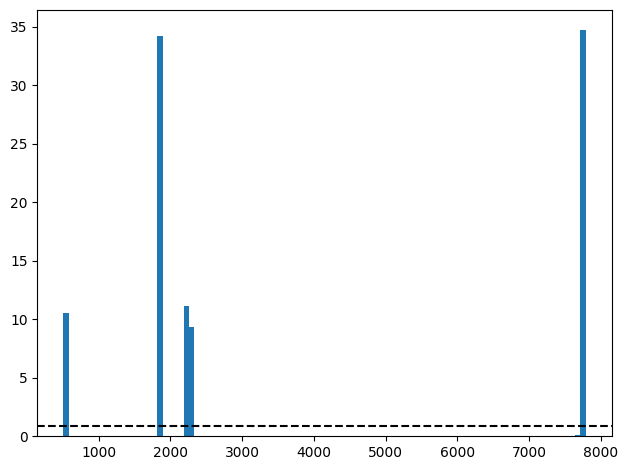

In [101]:
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int default=None
    args = parser.parse_args(auto.shlex.split(args))

    df = auto.pd.read_csv(
        '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/material.csv',
        index_col=['surface'],
        quoting=auto.csv.QUOTE_NONNUMERIC,
        nrows=args.limit,
    )

    def scope():
        data = df['value'].to_numpy()

        ntrash = auto.np.isnan(data).sum()
        ptrash = ntrash / len(data)

        data = data[~auto.np.isnan(data)]

        hist, bins = auto.np.histogram(data, bins=100)
        hist = hist / hist.sum() * 100

        fig = auto.plt.figure()
        ax = fig.add_subplot(111)
        ax.axhline(ptrash, ls='--', c='k')
        ax.bar(bins[:-1], hist, width=bins[1] - bins[0])

        /fig.tight_layout
        /display fig
        /auto.plt.close fig
    /scope

# ;scope --limit 100
;scope 


# 4th: Earth

## config.app

In [ ]:
#@title config.app
config.app = auto.types.SimpleNamespace()

config.app.satellite = (
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
)

def scope(lats: tuple[float, float], lngs: tuple[float, float], zoom: int):
    ret = {}

    latlo = min(lats)
    lathi = max(lats)
    lnglo = min(lngs)
    lnghi = max(lngs)

    ret['latlo'] = latlo
    ret['lathi'] = lathi
    ret['lnglo'] = lnglo
    ret['lnghi'] = lnghi

    ret['zoom'] = zoom

    col1, row1, _ = auto.mercantile.tile(lnglo, latlo, zoom)
    col2, row2, _ = auto.mercantile.tile(lnghi, lathi, zoom)

    ret['collo'] = min(col1, col2)
    ret['rowlo'] = min(row1, row2)
    ret['colhi'] = max(col1, col2)
    ret['rowhi'] = max(row1, row2)

    return ret

config.app.earth = scope(
    lats=(-85, 85),
    lngs=(-180, 180),
    zoom=3,
)

config.app.usa = scope(
    lats=(24, 50),
    lngs=(-124, -67),
    zoom=5,
)

config.app.tn = scope(
    lats=(34, 37),
    lngs=(-89, -81),
    zoom=9,
)

config.app.knox = scope(
    lats=(35, 36.1),
    lngs=(-88.38-1, -88.38+1),
    zoom=12,
)

/auto.pprint.pp config.app width=144


## Satellite

In [ ]:
try:
    _Satellite__12b18eaa
except NameError:
    _Satellite__12b18eaa = {}

#@title Satellite
class Satellite:
    was_cached = None

    def __new__(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        return Satellite.from_disk(row=row, col=col, zoom=zoom)

    @staticmethod
    def Tile(url: str, /) -> tuple[int, int, int]:
        path = auto.pathlib.PurePosixPath(url)
        col = int(path.name)
        path = path.parent
        row = int(path.name)
        path = path.parent
        zoom = int(path.name)

        return zoom, row, col

    @classmethod
    def load(Satellite, zpath: auto.os.PathLike, /):
        zpath = auto.pathlib.Path(zpath)
        with auto.zipfile.ZipFile(zpath, 'r') as arc:
            for name in arc.namelist():
                path = auto.zipfile.Path(arc, name)
                if path.is_dir():
                    continue

                zoom, row, col = Satellite.Tile(str(path.parent))
                with path.open('rb') as f:
                    image = auto.PIL.Image.open(f)
                    image.load()

                __12b18eaa[str(path.parent)] = image

    @classmethod
    def save(Satellite, zpath: auto.os.PathLike, /):
        zpath = auto.pathlib.Path(zpath)
        if zpath.exists():
            ztemp = zpath.parent / f'{zpath.name}.tmp'
            if ztemp.exists():
                ztemp.unlink()
            
            zpath.rename(ztemp)

        with auto.zipfile.ZipFile(zpath, 'w') as arc:
            root = auto.zipfile.Path(arc)

            for url, image in __12b18eaa.items():
                zoom, row, col = Satellite.Tile(url)

                with (path := root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png').open('wb') as f:
                    image.save(f, 'PNG')

        print(f'Wrote {zpath.stat().st_size:,d} bytes to {zpath}')

    @classmethod
    def from_disk(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        root = auto.zipfile.Path('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/satellite.zip')
        path = root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png'
        if not path.exists():
            Satellite.was_cached = False
            image = Satellite.from_http(row=row, col=col, zoom=zoom)
            # with path.open('wb') as f:
            #     image.save(f, 'PNG')

        else:
            Satellite.was_cached = True
            with path.open('rb') as f:
                image = auto.PIL.Image.open(f)
                image.load()

        return image

    @classmethod
    def from_http(Satellite, *, row: int, col: int, zoom: int) -> auto.PIL.Image:
        url = config.app.satellite.format(z=zoom, x=col, y=row)
        if url not in __12b18eaa:
            Satellite.was_cached = False

            with auto.requests.request(
                'GET',
                url,
                stream=True,
            ) as response:
                response.raise_for_status()

                image = auto.PIL.Image.open(auto.io.BytesIO(response.content))
                image.load()

            /auto.time.sleep 1
            __12b18eaa[url] = image

        else:
            Satellite.was_cached = True
            image = __12b18eaa[url]

        return image


def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    args = parser.parse_args(auto.shlex.split(args))

    _Satellite__12b18eaa.clear()

    Satellite.load(
        'data/__ac3095cf.zip',
    )

    Satellite.load(
        'data/satellite.zip',
    )

    Satellite.save(
        'data/satellite.zip',
    )

# ;scope


## Tiles

In [ ]:

#@title Tiles
def Tiles(
    *,
    latlo: float, lathi: float,
    lnglo: float, lnghi: float,
    zoom: int,
    collo: int, rowlo: int,
    colhi: int, rowhi: int,
    return_index: bool = False,
) -> auto.typing.Iterator[tuple[int, int, int]]:
    # n = iter(auto.itertools.count())

    rows = range(rowlo, 1 + rowhi)
    cols = range(collo, 1 + colhi)

    for (irow, row), (icol, col) in auto.itertools.product(
        enumerate(rows),
        enumerate(cols),
    ):
        # ul = auto.mercantile.ul(col, row, zoom)
        # if next(n) % 1000 == 0:
        #     print(ul)

        # if not (latlo <= ul.lat <= lathi):
        #     continue
        # if not (lnglo <= ul.lng <= lnghi):
        #     continue

        if return_index:
            yield zoom, (irow, row), (icol, col)
        else:
            yield zoom, row, col

def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--bounds' type=str required=True
    args = parser.parse_args(auto.shlex.split(args))

    bounds = getattr(config.app, args.bounds)

    output = None

    # with auto.zipfile.ZipFile((
    #     zpath := auto.pathlib.Path('/mnt/data/satellite.zip')
    # ), 'w', compression=(
    #     auto.zipfile.ZIP_DEFLATED
    # )) as arc:
    #     root = auto.zipfile.Path(arc)

    it = Tiles(
        **bounds,
    )
    it = list(it)
    it = auto.tqdm.auto.tqdm(it)

    # /auto.time.sleep 4

    for zoom, row, col in it:
        image = Satellite(row=row, col=col, zoom=zoom)

        if not Satellite.was_cached:
            if output is None:
                display(output := auto.ipywidgets.Output())

            output.clear_output(wait=True)
            with output:
                /display image

        # with (root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png').open('wb') as f:
        #     image.save(f, 'PNG')

    # print(f'Wrote {zpath.stat().st_size:,d} bytes to {zpath}')

# ;scope --bounds 'usa'
# ;scope --bounds 'tn'
;scope --bounds 'knox'


## Interpolator

In [ ]:
#@title Interpolator, Sample
# def Satellite(*, row: int, col: int, zoom: int) -> auto.PIL.Image:
#     root = auto.zipfile.Path('/mnt/data/satellite.zip')
#     path = root / f'{zoom}' / f'{row}' / f'{col}' / f'256.png'

#     with path.open('rb') as f:
#         image = auto.PIL.Image.open(f)
#         image.load()

#     return image

def Interpolator(func, /, *, method: str, bounds: dict[str, float]):
    zoom = bounds['zoom']

    # it = Tiles(
    #     **bounds,
    # )

    # lats = set()
    # lngs = set()
    # for zoom, row, col in it:
    #     for drow, dcol in auto.itertools.product(
    #         range(0, 256),
    #         repeat=2,
    #     ):
    #         ul = auto.mercantile.ul(col + dcol, row + drow, zoom + 8)
    #         lats.add(ul.lat)
    #         lngs.add(ul.lng)

    # lats = sorted(lats)
    # lngs = sorted(lngs)

    # lats = auto.np.array(lats)
    # lngs = auto.np.array(lngs)

    # assert lats.shape == lngs.shape, \
    #     f'{lats.shape} != {lngs.shape}'

    def Points():
        lngs = []
        for col in range(bounds['collo'], 1 + bounds['colhi']):
            for x in range(256 * (col + 0), 256 * (col + 1)):
                ul = auto.mercantile.ul(x, 0, zoom + 8)
                lngs.append(ul.lng)

        lats = []
        for row in range(bounds['rowlo'], 1 + bounds['rowhi']):
            for y in range(256 * (row + 0), 256 * (row + 1)):
                ul = auto.mercantile.ul(0, y, zoom + 8)
                lats.append(ul.lat)

        lats = auto.np.array(lats)
        lngs = auto.np.array(lngs)

        return lats, lngs
    lats, lngs = Points()

    # assert len(lats) == 2**zoom*256, \
    #     f'{lats.shape} != {2**zoom*256}'
    # assert len(lngs) == 2**zoom*256, \
    #     f'{lngs.shape} != {2**zoom*256}'
    # assert auto.np.isclose(min(lats), -85, rtol=1), \
    #     f'{min(lats)} != -85'
    # assert auto.np.isclose(max(lats), 85, rtol=1), \
    #     f'{max(lats)} != 85'
    # assert auto.np.isclose(min(lngs), -180, rtol=1), \
    #     f'{min(lngs)} != -180'
    # assert auto.np.isclose(max(lngs), 180, rtol=1), \
    #     f'{max(lngs)} != 180'

    # lats = auto.np.linspace(90, -90, num=2**args.zoom*256)
    # lngs = auto.np.linspace(-180, 180, num=2**args.zoom*256)
    values = auto.np.empty((
        lats.shape[0],
        lngs.shape[0],
        3,
    ))

    it = Tiles(
        **bounds,
        return_index=True,
    )
    it = list(it)
    it = auto.tqdm.auto.tqdm(it)

    for _, (irow, row), (icol, col) in it:
        image = func(zoom=zoom, row=row, col=col)
        image = auto.np.array(image)
        assert image.shape == (256, 256, 3)

        values[
            (irow+0)*256 : (irow+1)*256,
            (icol+0)*256 : (icol+1)*256,
        ] = image

    interpolator = auto.scipy.interpolate.RegularGridInterpolator(
        points=(
            lats,
            lngs,
        ),
        values=values,
        method=method,
        bounds_error=False,
        fill_value=(255, 255, 255),
    )

    return interpolator




## Sample

In [ ]:
def Sample(
    interpolator,
    /,
    *,
    lats: auto.np.ndarray[float],
    lngs: auto.np.ndarray[float],
):
    assert len(lats.shape) == 1
    assert len(lngs.shape) == 1

    Y = lats
    X = lngs
    YY, XX = auto.np.meshgrid(Y, X)
    YX = auto.np.c_[YY.ravel(), XX.ravel()]
    Z = interpolator(YX)
    ZZ = Z.reshape([*YY.shape, 3])
    ZZ = ZZ.swapaxes(0, 1)

    assert ZZ.shape == (len(lats), len(lngs), 3)
    return ZZ


## look

In [ ]:
#@title look
def scope(args: str, /):
    def csv(s: str): return tuple(map(float, s.split(',')))

    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--bounds' type=str required=True
    /parser.add_argument '--view-lats' type=csv
    /parser.add_argument '--view-lngs' type=csv
    /parser.add_argument '--method' type=str default='nearest'
    /parser.add_argument '--resolution' type=int default=256
    args = parser.parse_args(auto.shlex.split(args))

    bounds = getattr(config.app, args.bounds)

    if args.view_lats is None:
        args.view_lats = (bounds['latlo'], bounds['lathi'])
    if args.view_lngs is None:
        args.view_lngs = (bounds['lnglo'], bounds['lnghi'])

    satellite = Interpolator(
        Satellite,
        method=args.method,
        bounds=bounds,
    )

    def scope():
        N = args.resolution
        lats = auto.np.linspace(*args.view_lats, num=N)
        lngs = auto.np.linspace(*args.view_lngs, num=N)

        RGB = 1.0 / 255.0 * Sample(
            satellite,
            lats=lats,
            lngs=lngs,
        )

        fig = auto.plt.figure()
        ax = fig.add_subplot(111)

        ax.imshow(
            RGB,
            extent=[*args.view_lngs, *args.view_lats],
            aspect='equal',
            interpolation='nearest',
            origin='lower',
        )

        /fig.tight_layout
        /display fig
        /auto.plt.close fig
    if args.view_lats is not None and args.view_lngs is not None:
        /scope

;scope \
    --bounds 'earth' \
    --resolution 1024 \
    --method=nearest

;scope \
    --bounds 'usa' \
    --resolution 1024 \
    --method=nearest

;scope \
    --bounds 'tn' \
    --resolution 1024 \
    --method=nearest

;scope \
    --bounds 'knox' \
    --resolution 1024 \
    --method=nearest

# ;scope --zoom=8 \
#     --bounds 'tn' \
#     --resolution 1024 \
#     --method=nearest

# ;scope --zoom=5 \
#     --resolution 1024 \
#     --method=nearest \
#     --view-lngs=-124.7844079,-66.9513812 \
#     --view-lats=24.7433195,49.3457868


## save OSPRay

In [ ]:
#@title save
def scope(args: str, /):
    def csv(s: str): return tuple(map(float, s.split(',')))

    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--lats' type=csv
    /parser.add_argument '--lngs' type=csv
    /parser.add_argument '--method' type=str default='nearest'
    /parser.add_argument '--resolution' type=int default=256
    /parser.add_argument '--bounds' type=str required=True
    /parser.add_argument '--save' type=auto.pathlib.Path required=True
    args = parser.parse_args(auto.shlex.split(args))

    args.save.parent.mkdir(exist_ok=True, parents=True)

    bounds = getattr(config.app, args.bounds)
    if args.lats is None:
        args.lats = (bounds['latlo'], bounds['lathi'])
    if args.lngs is None:
        args.lngs = (bounds['lnglo'], bounds['lnghi'])

    /auto.pprint.pp args

    if not args.save.exists():
        args.save.mkdir(parents=True)
    assert args.save.is_dir(), 'save must be a directory'

    satellite = Interpolator(
        Satellite,
        method=args.method,
        bounds=bounds,
    )

    lats = auto.np.linspace(*args.lats, num=args.resolution)
    lngs = auto.np.linspace(*args.lngs, num=args.resolution)

    def scope():
        LAT = lats
        LNG = lngs
        ALT = 0
        LATS, LNGS = auto.np.meshgrid(LAT, LNG, indexing='ij')

        X, Y, Z = Spatial(
            lat=LATS.ravel(),
            lng=LNGS.ravel(),
            alt=0,
        )
        XYZ = auto.np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
        assert XYZ.shape == (args.resolution * args.resolution, 3)
        if XYZ.dtype != auto.np.float32:
            XYZ = XYZ.astype('f4')
        assert XYZ.dtype == auto.np.float32

        return XYZ
    XYZ = scope()

    def scope():
        RGB = 1.0 / 255.0 * Sample(
            satellite,
            lats=lats,
            lngs=lngs,
        )
        RGB = RGB.reshape((args.resolution * args.resolution, 3))
        assert RGB.shape == (args.resolution * args.resolution, 3)
        if RGB.dtype != auto.np.float32:
            RGB = RGB.astype('f4')
        assert RGB.dtype == auto.np.float32

        return RGB
    RGB = scope()

    def scope():
        H = len(lats)
        W = len(lngs)

        num_quads = (W - 1) * (H - 1)
        num_tris = num_quads * 2
        N = num_tris

        print(f'Creating {N:,d} triangles')

        I = auto.np.full(3 * N, 0xFFFFFFFF, dtype='u4')
        count = iter(auto.itertools.count())
        for r in range(1, H):
            for c in range(1, W):
                i0 = (r - 1) * W + (c - 1)
                i1 = (r - 1) * W + (c - 0)
                i2 = (r - 0) * W + (c - 1)
                i3 = (r - 0) * W + (c - 0)

                I[next(count)] = i0
                I[next(count)] = i1
                I[next(count)] = i2

                I[next(count)] = i2
                I[next(count)] = i1
                I[next(count)] = i3
        assert not auto.np.any(I == 0xFFFFFFFF), \
            f"Didn't populate all {N} triangles"

        I = I.reshape((N, 3))

        return I
    I = scope()

    assert XYZ.shape == RGB.shape, (XYZ.shape, RGB.shape)

    assert XYZ.dtype == 'f4', XYZ.dtype
    print(XYZ.shape, XYZ.dtype)
    with (path := args.save / 'OSPGeometry.mesh.vec3f[].vertex.position.bin').open('wb') as f:
        f.write(XYZ.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

    assert RGB.dtype == 'f4', RGB.dtype
    print(RGB.shape, RGB.dtype)
    with (path := args.save / 'OSPGeometry.mesh.vec3f[].vertex.color.bin').open('wb') as f:
        f.write(RGB.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

    assert I.dtype == 'u4', I.dtype
    print(I.shape, I.dtype)
    with (path := args.save / 'OSPGeometry.mesh.vec3ui[].index.bin').open('wb') as f:
        f.write(I.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

;scope --bounds 'earth' \
    --resolution 4096 \
    --method=nearest \
    --save data/city/Earth

;scope --bounds 'usa' \
    --resolution 4096 \
    --method=nearest \
    --save data/city/USA

;scope --bounds 'tn' \
    --resolution 4096 \
    --method=nearest \
    --save data/city/TN

;scope --bounds 'knox' \
    --resolution 4096 \
    --method=nearest \
    --save data/city/Knox


## look

In [ ]:
#@title look
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--load' type=auto.pathlib.Path required=True
    args = parser.parse_args(auto.shlex.split(args))

    assert args.load.exists(), f'file {args.load} does not exist'
    assert args.load.is_dir(), f'file {args.load} is not a directory'

    with (path := args.load / 'OSPGeometry.mesh.vec3f[].vertex.position.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(3 * 100),
            dtype=[ ('x', 'f4'), ('y', 'f4'), ('z', 'f4') ],
        )
        print(data)

    with (path := args.load / 'OSPGeometry.mesh.vec3f[].vertex.color.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(3 * 100),
            dtype=[ ('r', 'f4'), ('g', 'f4'), ('b', 'f4') ],
        )
        print(data)

    with (path := args.load / 'OSPGeometry.mesh.vec3ui[].index.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(3 * 100),
            dtype=[ ('i', 'u4'), ('j', 'u4'), ('k', 'u4') ],
        )
        print(data)

;scope \
    --load /mnt/data/Earth


# 5th: SQLite -> OSPRay

## config.app

In [86]:
#@title config.app
config.app = auto.types.SimpleNamespace()

config.app.datadir = auto.pathlib.Path((
    '/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen'
    # '/mnt/data/'
))

config.app.geometry = auto.pathlib.Path((
    config.app.datadir / 'geometry.csv'
))

config.app.material = auto.pathlib.Path((
    config.app.datadir / 'material.csv'
))

/auto.pprint.pp config.app width=144


namespace(datadir=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen'),
          geometry=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/geometry.csv'),
          material=PosixPath('/mnt/seenas2/data/2023_ORNL_Building_Energy_Models/gen/material.csv'))


## look

In [91]:
#@title look
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int default=None
    args = parser.parse_args(auto.shlex.split(args))

    geometry = auto.pd.read_csv(
        config.app.geometry,
        index_col=['surface'],
        quoting=auto.csv.QUOTE_NONNUMERIC,
        nrows=args.limit,
    )

    xlo = geometry['xlo'].min()
    ylo = geometry['ylo'].min()
    zlo = geometry['zlo'].min()
    xhi = geometry['xhi'].max()
    yhi = geometry['yhi'].max()
    zhi = geometry['zhi'].max()

    print(f'xlo: {xlo}')
    print(f'ylo: {ylo}')
    print(f'zlo: {zlo}')
    print(f'xhi: {xhi}')
    print(f'yhi: {yhi}')
    print(f'zhi: {zhi}')

    /print

    xrange = xhi - xlo
    yrange = yhi - ylo
    zrange = zhi - zlo

    print(f'xrange: {xrange}')
    print(f'yrange: {yrange}')
    print(f'zrange: {zrange}')

    /print

    xmid = (xlo + xhi) / 2
    ymid = (ylo + yhi) / 2
    zmid = (zlo + zhi) / 2

    print(f'xmid: {xmid}')
    print(f'ymid: {ymid}')
    print(f'zmid: {zmid}')

;scope --limit 100


xlo: -88.4690072876971
ylo: 35.4378358783422
zlo: 0.0
xhi: -88.29548521435653
yhi: 35.496352733099535
zhi: 20.68000066176

xrange: 0.17352207334056402
yrange: 0.058516854757336034
zrange: 20.68000066176

xmid: -88.38224625102681
ymid: 35.46709430572086
zmid: 10.34000033088


## save geometry OSPRay

In [99]:
#@title Create Geometry & Index
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--limit' type=int default=None
    /parser.add_argument '--save' type=auto.pathlib.Path required=True
    args = parser.parse_args(auto.shlex.split(args))

    if not args.save.exists():
        args.save.mkdir()
    assert args.save.exists()
    assert args.save.is_dir()

    geometry = auto.pd.read_csv(
        config.app.geometry,
        index_col=['surface'],
        quoting=auto.csv.QUOTE_NONNUMERIC,
        nrows=args.limit,
    )
    loc2i = { loc: i for i, loc in enumerate(geometry.index) }
    i2loc = { i: loc for i, loc in enumerate(geometry.index) }
    N = len(geometry.index)

    material = auto.pd.read_csv(
        config.app.material,
        index_col=['surface'],
        quoting=auto.csv.QUOTE_NONNUMERIC,
        nrows=args.limit,
    )

    vlo = material['value'].min()
    vhi = material['value'].max()
    value = material[[
        'value',
    ]].to_numpy().astype('f4')
    value = auto.np.where(auto.np.isnan(value), 0, (1 + 255 * (value - vlo) / (1 + 255 *(vhi - vlo))))
    
    data = geometry[[
        'xlo', 'ylo', 'zlo',
        'xhi', 'yhi', 'zhi',
    ]].to_numpy().astype('f4')

    NBOX = len(data)
    NVERT = 8 * NBOX
    NQUAD = 6 * NBOX

    VERT = iter(auto.itertools.count())
    QUAD = iter(auto.itertools.count())

    MAT = iter(auto.itertools.count())

    verts = auto.np.full((NVERT, 3), fill_value=0.373737, dtype='f4')
    quads = auto.np.full((NQUAD, 4), fill_value=auto.np.iinfo('u4').max, dtype='u4')
    mats = auto.np.full((NQUAD, 1), fill_value=255, dtype='u1')

    LAT, LNG, ALT = range(3)
    LNGLO, LATLO, ALTLO, LNGHI, LATHI, ALTHI = range(6)

    it = zip(data, value)
    it = auto.tqdm.auto.tqdm(it, total=len(data))

    tmp_l = auto.np.zeros((8, 3))
    tmp_s = auto.np.zeros((8, 3))
    for row, v in it:
        TMP_L = iter(auto.itertools.count())

        tmp_l[(vi000 := next(TMP_L)), :] = (row[LATLO], row[LNGLO], row[ALTLO])
        tmp_l[(vi001 := next(TMP_L)), :] = (row[LATLO], row[LNGLO], row[ALTHI])
        tmp_l[(vi010 := next(TMP_L)), :] = (row[LATLO], row[LNGHI], row[ALTLO])
        tmp_l[(vi011 := next(TMP_L)), :] = (row[LATLO], row[LNGHI], row[ALTHI])
        tmp_l[(vi100 := next(TMP_L)), :] = (row[LATHI], row[LNGLO], row[ALTLO])
        tmp_l[(vi101 := next(TMP_L)), :] = (row[LATHI], row[LNGLO], row[ALTHI])
        tmp_l[(vi110 := next(TMP_L)), :] = (row[LATHI], row[LNGHI], row[ALTLO])
        tmp_l[(vi111 := next(TMP_L)), :] = (row[LATHI], row[LNGHI], row[ALTHI])

        # print(tmp_l[..., LAT])
        # print(tmp_l[..., LNG])
        # print(tmp_l[..., ALT])
        # return

        for i in range(8):
            tmp_s[i] = Spatial(
                lat=tmp_l[i, LAT],
                lng=tmp_l[i, LNG],
                alt=tmp_l[i, ALT],
            )
        # tmp_s[:] = Spatial(
        #     lat=tmp_l[..., LAT],
        #     lng=tmp_l[..., LNG],
        #     alt=tmp_l[..., ALT],
        # )

        # return
        verts[(v000 := next(VERT))] = tmp_s[vi000]
        verts[(v001 := next(VERT))] = tmp_s[vi001]
        verts[(v010 := next(VERT))] = tmp_s[vi010]
        verts[(v011 := next(VERT))] = tmp_s[vi011]
        verts[(v100 := next(VERT))] = tmp_s[vi100]
        verts[(v101 := next(VERT))] = tmp_s[vi101]
        verts[(v110 := next(VERT))] = tmp_s[vi110]
        verts[(v111 := next(VERT))] = tmp_s[vi111]

        quads[next(QUAD), :] = (v000, v001, v101, v110) # BOTTOM
        quads[next(QUAD), :] = (v010, v011, v111, v110) # TOP
        quads[next(QUAD), :] = (v000, v010, v011, v001) # LEFT
        quads[next(QUAD), :] = (v110, v111, v101, v100) # RIGHT
        quads[next(QUAD), :] = (v000, v010, v110, v100) # FRONT
        quads[next(QUAD), :] = (v001, v011, v111, v101) # BACK

        mats[next(MAT)] = v
        mats[next(MAT)] = v
        mats[next(MAT)] = v
        mats[next(MAT)] = v
        mats[next(MAT)] = v
        mats[next(MAT)] = v

    i = next(VERT)
    assert i == len(verts), f'i = {i}. len(verts) = {len(verts)}'
    i = next(QUAD)
    assert i == len(quads), f'i = {i}. len(quads) = {len(quads)}'
    i = next(MAT)
    assert i == len(mats), f'i = {i}. len(mats) = {len(mats)}'
    
    # assert data.shape == (N, 6)
    # data = data.reshape(N, 2, 3)
    # lng = data[..., 0]
    # lat = data[..., 1]
    # alt = data[..., 2]

    # X, Y, Z = Spatial(
    #     lat=lat,
    #     lng=lng,
    #     alt=alt,
    # )
    # data[..., 0] = X
    # data[..., 1] = Y
    # data[..., 2] = Z
    # data = data.reshape(N, 6)
    # assert data.shape == (N, 6)


    # mids = (data[:, 3:] + data[:, :3]) / 2
    # rngs = (data[:, 3:] - data[:, :3]) / 2


    # # data[:, :3] = mids - 10 * rngs * 10
    # # data[:, 3:] = mids + 10 * rngs * 10
    # # data[:, :3] = mids - 10 * rngs 
    # # data[:, 3:] = mids + 10 * rngs

    with (path := args.save / 'TOSPGeometry.mesh.vec3f[].vertex.position.bin').open('wb') as f:
        f.write(verts.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')
    
    with (path := args.save / 'TOSPGeometry.mesh.vec4u[].index.bin').open('wb') as f:
        f.write(quads.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

    # vlo = material['value'].min()
    # vhi = material['value'].max()

    # data = material[[
    #     'value',
    # ]].to_numpy().astype('f4')
    # data = auto.np.where(auto.np.isnan(data), 0, 1 + 255 * (data - vlo) / (vhi - vlo))

    
    with (path := args.save / 'TOSPGeometricModel.uchar[].index.bin').open('wb') as f:
        f.write(mats.tobytes())
    print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

# RUNNING
# ;scope --limit 100 \
#     --save-geometry /mnt/data/OSPGeometry.box.box3f[].box.bin \
#     --save-material /mnt/data/OSPGeometricModel.uint8[].index.bin
;scope \
    --save data/city/Building


Wrote 541,005,984 bytes to data/city/Building/TOSPGeometry.mesh.vec3f[].vertex.position.bin
Wrote 541,005,984 bytes to data/city/Building/TOSPGeometry.mesh.vec4u[].index.bin
Wrote 33,812,874 bytes to data/city/Building/TOSPGeometricModel.uchar[].index.bin


In [57]:
# def scope():
#     with auto.pathlib.Path(path := 'data/city/Building/TOSPGeometricModel.uchar[].index.bin').open('rb') as f:
#         data = auto.np.frombuffer(
#             f.read(), dtype='u1'
#         )
    
#     n = len(data)
#     tmp = auto.np.empty((6, n), dtype='u1')

#     tmp[0, :] = data
#     tmp[1, :] = data
#     tmp[2, :] = data
#     tmp[3, :] = data
#     tmp[4, :] = data
#     tmp[5, :] = data
    
#     with (path := auto.pathlib.Path('data/city/Building/TOSPGeometricModel.uchar[].index.bin')).open('wb') as fout:
#         fout.write(tmp.tobytes())
#     print(f'Wrote {path.stat().st_size:,d} bytes to {path}')

# /scope

Wrote 135,251,496 bytes to data/city/Building/TOSPGeometricModel.uchar[].index.bin


## look

In [95]:
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--load' type=auto.pathlib.Path required=True
    args = parser.parse_args(auto.shlex.split(args))

    with (path := args.load / 'TOSPGeometry.mesh.vec3f[].vertex.position.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(6 * 4 * 100),
            dtype=[
                ('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
            ],
        )
        print(data)

    with (path := args.load / 'TOSPGeometricModel.uchar[].index.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(100),
            dtype=[
                ('i', 'u1'),
            ],
        )
        print(data)

;scope \
    --load data/city/Building

[(138.59744, 3699.3223, -5185.1177) (138.5975 , 3699.324 , -5185.12  )
 (138.59744, 3699.3223, -5185.1177) (138.5975 , 3699.324 , -5185.12  )
 (138.59732, 3699.3284, -5185.1133) (138.59738, 3699.33  , -5185.1157)
 (138.59732, 3699.3284, -5185.1133) (138.59738, 3699.33  , -5185.1157)
 (138.58351, 3699.3284, -5185.114 ) (138.58357, 3699.33  , -5185.116 )
 (138.59732, 3699.3284, -5185.1133) (138.59738, 3699.33  , -5185.1157)
 (138.58351, 3699.3284, -5185.114 ) (138.58357, 3699.33  , -5185.116 )
 (138.59732, 3699.3284, -5185.1133) (138.59738, 3699.33  , -5185.1157)
 (138.58363, 3699.3223, -5185.118 ) (138.5837 , 3699.324 , -5185.1206)
 (138.58363, 3699.3223, -5185.118 ) (138.5837 , 3699.324 , -5185.1206)
 (138.58351, 3699.3284, -5185.114 ) (138.58357, 3699.33  , -5185.116 )
 (138.58351, 3699.3284, -5185.114 ) (138.58357, 3699.33  , -5185.116 )
 (138.58363, 3699.3223, -5185.118 ) (138.5837 , 3699.324 , -5185.1206)
 (138.59744, 3699.3223, -5185.1177) (138.5975 , 3699.324 , -5185.12  )
 (138.

In [92]:
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--load' type=auto.pathlib.Path required=True
    args = parser.parse_args(auto.shlex.split(args))

    with (path := args.load / 'TOSPGeometry.box.box3f[].box.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(6 * 4 * 100),
            dtype=[
                ('xlo', 'f4'), ('ylo', 'f4'), ('zlo', 'f4'),
                ('xhi', 'f4'), ('yhi', 'f4'), ('zhi', 'f4'),
            ],
        )
        print(data)

    with (path := args.load / 'TOSPGeometricModel.uchar[].index.bin').open('rb') as f:
        data = auto.np.frombuffer(
            f.read(100),
            dtype=[
                ('i', 'u1'),
            ],
        )
        print(data)

;scope \
    --load data/city/Building


[(138.59727, 3699.322 , -5185.1177, 138.59723, 3699.3303, -5185.1157)
 (138.58357, 3699.3286, -5185.114 , 138.59723, 3699.3303, -5185.1157)
 (138.5837 , 3699.322 , -5185.118 , 138.58363, 3699.3303, -5185.116 )
 (138.5837 , 3699.322 , -5185.118 , 138.59734, 3699.3237, -5185.12  )
 (138.58376, 3699.3237, -5185.1206, 138.5837 , 3699.332 , -5185.1187)
 (138.58376, 3699.3237, -5185.1206, 138.5974 , 3699.3254, -5185.1226)
 (138.59734, 3699.3237, -5185.12  , 138.59729, 3699.332 , -5185.118 )
 (138.58363, 3699.3303, -5185.116 , 138.59729, 3699.332 , -5185.118 )
 (138.5974 , 3699.3254, -5185.1226, 138.59737, 3699.3337, -5185.1206)
 (138.5837 , 3699.332 , -5185.1187, 138.59737, 3699.3337, -5185.1206)
 (138.58382, 3699.3254, -5185.1226, 138.58376, 3699.3337, -5185.121 )
 (138.58382, 3699.3254, -5185.1226, 138.59747, 3699.3271, -5185.125 )
 (138.59747, 3699.3271, -5185.125 , 138.59743, 3699.3354, -5185.123 )
 (138.58376, 3699.3337, -5185.121 , 138.59743, 3699.3354, -5185.123 )
 (138.58388, 3699.32

## save colormap OSPRay

In [102]:
#@title Create Colormap
def scope(args: str, /):
    parser = auto.argparse.ArgumentParser()
    /parser.add_argument '--save' type=auto.pathlib.Path
    args = parser.parse_args(auto.shlex.split(args))

    if args.save is not None:
        if not args.save.exists():
            args.save.mkdir(parents=True)
        assert args.save.is_dir()

    colors = \
    [ 
    #'#B301B3', '#B307B0', '#B30BAE', '#B311AC', '#B314AA', '#B318A8'
    # , '#B31BA6', '#B31FA4', '#B323A2', '#B325A1', '#B3289F', '#B32B9E'
    # , '#B32E9D', '#B3309C', '#B4339A', '#B43699', '#B53898', '#B63B97'
    # , '#B63D96', '#B74095', '#B84394', '#B84593', '#B94892', '#BA4A92'
    # , '#BB4C91', '#BC4E90', '#BC518F', '#BD548E', '#BE558E', '#BF588D'
    
     '#BF5A8C', '#C05C8B', '#C15E8B', '#C2618A', '#C36389', '#C36588'
    , '#C46888', '#C56987', '#C66C86', '#C66E86', '#C77085', '#C87384'
    , '#C87483', '#C97783', '#CA7982', '#CA7B81', '#CB7D81', '#CC7F80'
    , '#CC827F', '#CD847F', '#CE867E', '#CE887E', '#CF8A7D', '#CF8D7C'
    , '#D08F7C', '#D1917B', '#D1937B', '#D2967A', '#D2977A', '#D39A79'
    , '#D39D78', '#D49E78', '#D4A177', '#D5A377', '#D6A576', '#D6A776'
    
    # , '#D7AA75', '#D7AD74', '#D8AE74', '#D8B173', '#D9B373', '#DAB572'
    # , '#DAB772', '#DBBA71', '#DBBD70', '#DCBF70', '#DDC16F', '#DDC36F'
    # , '#DEC66E', '#DEC86E', '#DFCA6D', '#E0CD6C', '#E0CF6C', '#E1D26B'
    # , '#E1D46B', '#E2D76A', '#E3DA69', '#E4DC69', '#E5DF68', '#E6E168'
    # , '#E8E467', '#E9E667', '#EBE967', '#EEED67', '#F0EF66', '#F3F366'
    # , '#F6F566', '#F9F966', '#FBFB66', '#FFFF66'
    ]

    # cmap = auto.matplotlib.colors.ListedColormap(colors)
    # cmap: 'pink'
    cmap = auto.matplotlib.colormaps.get_cmap('pink')
    norm = auto.matplotlib.colors.Normalize(vmin=0, vmax=255)

    colors = []
    for i in range(256):
        r, g, b, a = cmap(norm(i))
        colors.append((r, g, b))

    colors = colors[::-1]

    colors[0] = (0, 0, 0)

    if args.save is not None:
        with (path := args.save / 'OSPMaterial[].obj.vec3f.kd.bin').open('wb') as f:
            for color in colors:
                f.write(auto.struct.pack('fff', *(
                    color[0],
                    color[1],
                    color[2],
                )))

    else:
        colors_ = colors
        colors = []
        for r, g, b in colors_:
            r = '%02X' % int(255 * r)
            g = '%02X' % int(255 * g)
            b = '%02X' % int(255 * b)
            colors.append(f'#{r}{g}{b}')

        display(auto.IPython.display.HTML(auto.mediocreatbest.TEMPLATE(r'''
            <div style="display: flex; flex-wrap: wrap; width: 512px;">
                {%- for color in colors %}
                <div style="
                    {#- #}display: block;
                    {#- #}background-color: {{ color }};
                    {#- #}width: 32px;
                    {#- #}height: 32px;
                    {#- #}margin: 0;
                    {#- #}padding: 0;
                "></div>
                {%- endfor %}
            </div>
        ''', **locals())))

# ;scope

;scope \
    --save data/Building


SyntaxError: invalid syntax (154352891.py, line 19)

# end